# Analisis Exploratorio

Librerias:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

c:\Users\andre\OneDrive\Documentos\GitHub\CC3084_Laboratorio3\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Si la serie de tiempo tiene una columna de fechas, asegúrate de que esté en formato datetime
df = pd.read_csv("./Datos/monthly-mean-temp.csv")
df['Month'] = pd.to_datetime(df['Month'])
df.head()

,Month,Temperature
0,1920-01-01,40.6
1,1920-02-01,40.8
2,1920-03-01,44.4
3,1920-04-01,46.7
4,1920-05-01,54.1


In [3]:
# Realizar un análisis descriptivo básico
df.describe()

,Month,Temperature
count,240,240.000000
mean,1929-12-15 23:00:00,49.041250
min,1920-01-01 00:00:00,31.300000
25%,1924-12-24 06:00:00,41.550000
50%,1929-12-16 12:00:00,47.350000
75%,1934-12-08 18:00:00,57.000000
max,1939-12-01 00:00:00,66.500000
std,NaN,8.569705


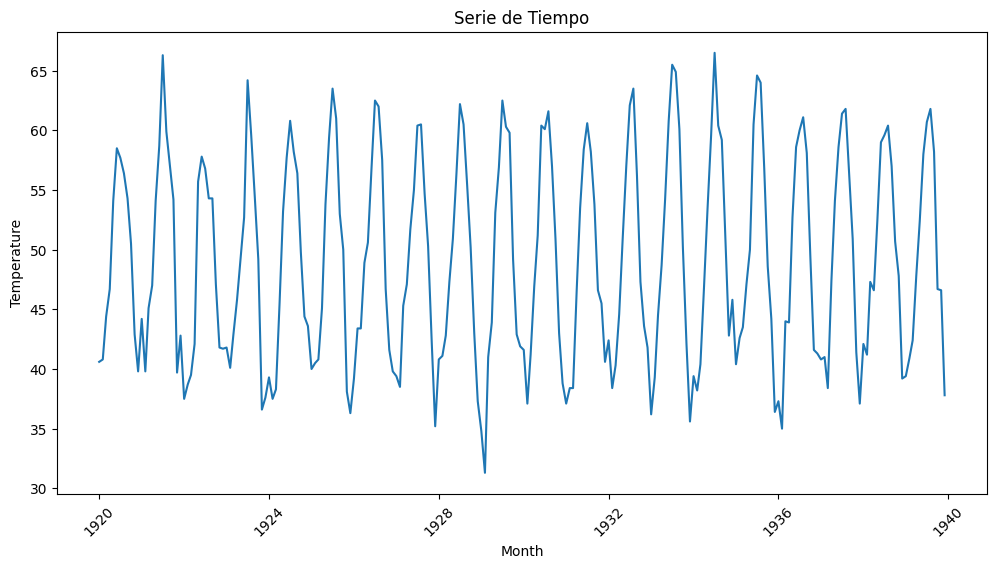

In [4]:
# Crear el gráfico de la serie de tiempo
plt.figure(figsize=(12, 6))  # Establece el tamaño de la figura

# Utiliza plt.plot para trazar la serie de tiempo
plt.plot(df['Month'], df['Temperature'])

# Personaliza el gráfico
plt.title("Serie de Tiempo")
plt.xlabel("Month")
plt.ylabel("Temperature")
plt.xticks(rotation=45)  # Rota las etiquetas del eje x para mayor legibilidad

# Muestra el gráfico
plt.show()


# Promedios

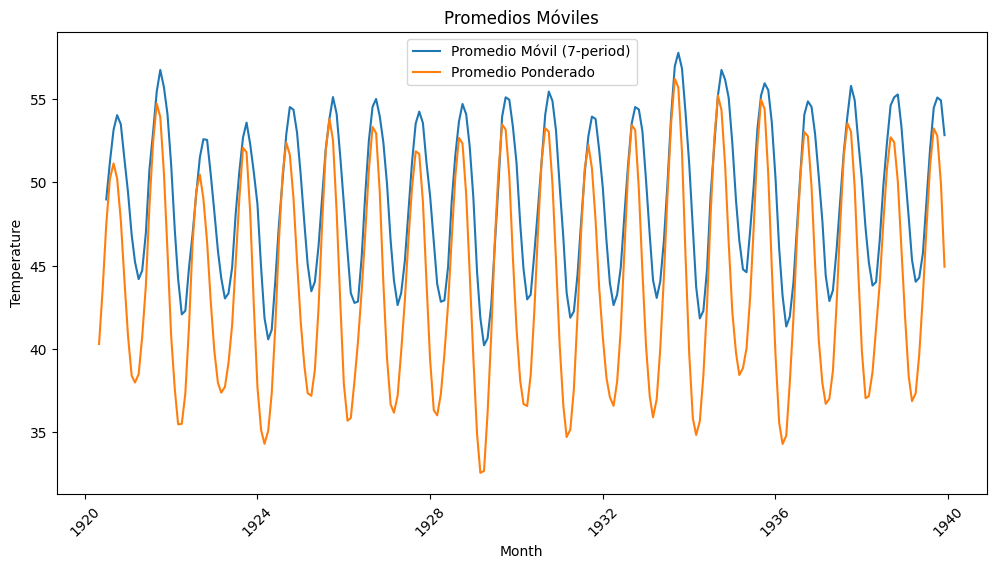

In [5]:
# Calcula el promedio móvil simple con una ventana de tamaño 7
window_size = 7
df['promedio_movil'] = df['Temperature'].rolling(window=window_size).mean()
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['promedio_movil'], label=f'Promedio Móvil ({window_size}-period)')

# Calcula un promedio ponderado
weights = [0.1, 0.2, 0.3, 0.2, 0.1]  # Ponderaciones para el promedio ponderado
df['promedio_ponderado'] = df['Temperature'].rolling(window=len(weights)).apply(lambda x: (x * weights).sum())
plt.plot(df['Month'], df['promedio_ponderado'], label='Promedio Ponderado')

plt.legend()
plt.title("Promedios Móviles")
plt.xlabel("Month")
plt.ylabel("Temperature")
plt.xticks(rotation=45)  # Rota las etiquetas del eje x para mayor legibilidad
plt.show()


# Sarima

                                     SARIMAX Results                                     
Dep. Variable:                       Temperature   No. Observations:                  240
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -677.050
Date:                           Mon, 04 Sep 2023   AIC                           1364.099
Time:                                   14:19:40   BIC                           1381.333
Sample:                                        0   HQIC                          1371.049
                                           - 240                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7098      0.090      7.870      0.000       0.533       0.887
ma.L1         -0.9998      7.405     -0.135

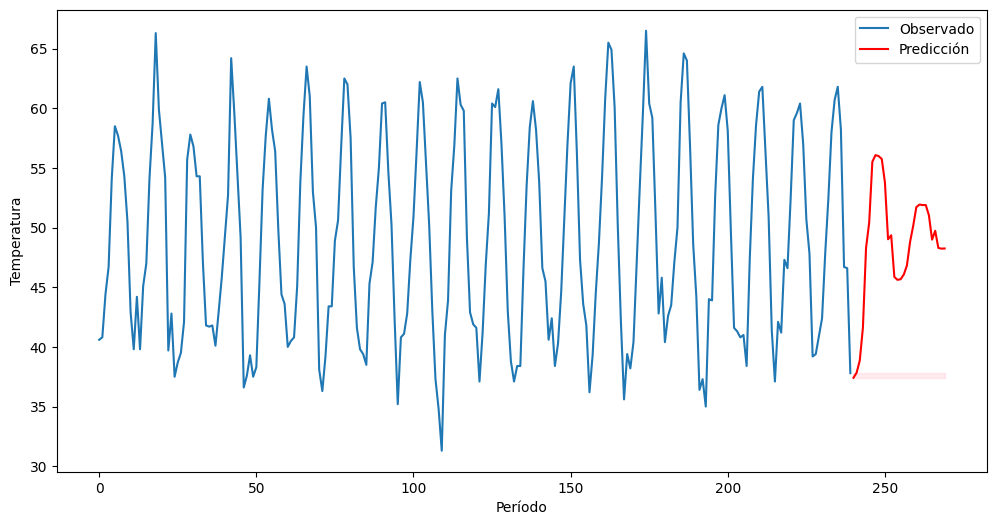

In [6]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Ajustar un modelo SARIMA
p, d, q = 1, 1, 1  # Órdenes para el componente ARIMA
P, D, Q, S = 1, 1, 1, 7  # Órdenes para el componente estacional

model = sm.tsa.SARIMAX(df['Temperature'], order=(p, d, q), seasonal_order=(P, D, Q, S))
results = model.fit()

# Ver el resumen del modelo
print(results.summary())

# Realizar predicciones
forecast_period = 30  # Número de períodos a predecir
forecast = results.get_forecast(steps=forecast_period)
forecast_mean = forecast.predicted_mean

# Convertir el índice de fechas en una secuencia de números enteros
date_integer_index = range(len(df), len(df) + forecast_period)
forecast_mean.index = date_integer_index
forecast.conf_int().index = date_integer_index

# Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(range(len(df)), df['Temperature'], label='Observado')
plt.plot(date_integer_index, forecast_mean.values, label='Predicción', color='red')
plt.fill_between(date_integer_index, forecast_mean.values[0], forecast_mean.values[1], color='pink', alpha=0.3)
plt.xlabel('Período')
plt.ylabel('Temperatura')
plt.legend()
plt.show()


# Aislamiento Exponencial

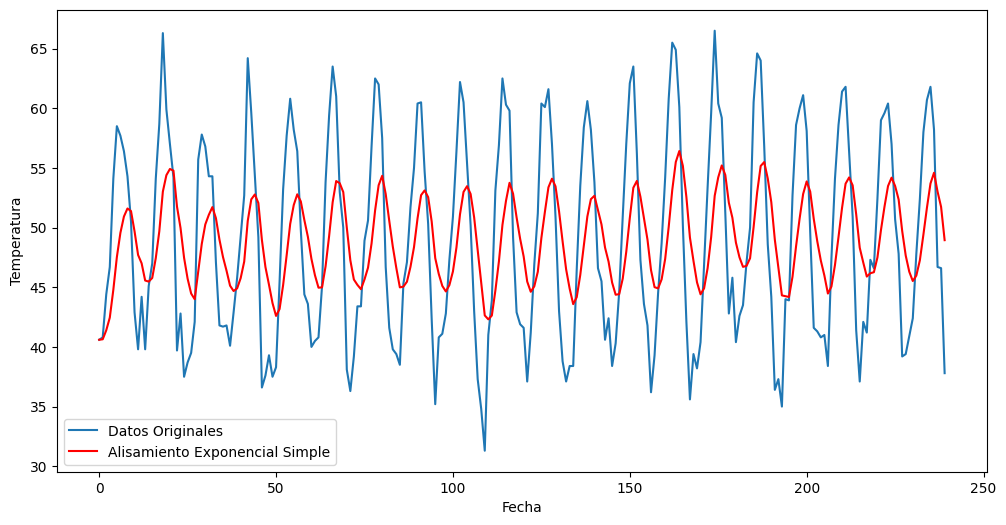

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Función para el alisamiento exponencial simple
def exponential_smoothing(series, alpha):
    result = [series[0]]  # El primer valor es igual al primer punto de datos
    for t in range(1, len(series)):
        result.append(alpha * series[t] + (1 - alpha) * result[t - 1])
    return result

# Parámetro alpha (factor de suavizado)
alpha = 0.2  # Puedes ajustar este valor según tus necesidades

# Aplicar el alisamiento exponencial simple
smoothed_temperature = exponential_smoothing(df['Temperature'], alpha)

# Visualizar los datos originales y el alisamiento
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Temperature'], label='Datos Originales')
plt.plot(df.index, smoothed_temperature, label='Alisamiento Exponencial Simple', color='red')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.show()


# Prophet

14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\andre\OneDrive\Documentos\GitHub\CC3084_Laboratorio3\.venv\lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\andre\OneDrive\Documentos\GitHub\CC3084_Laboratorio3\.venv\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


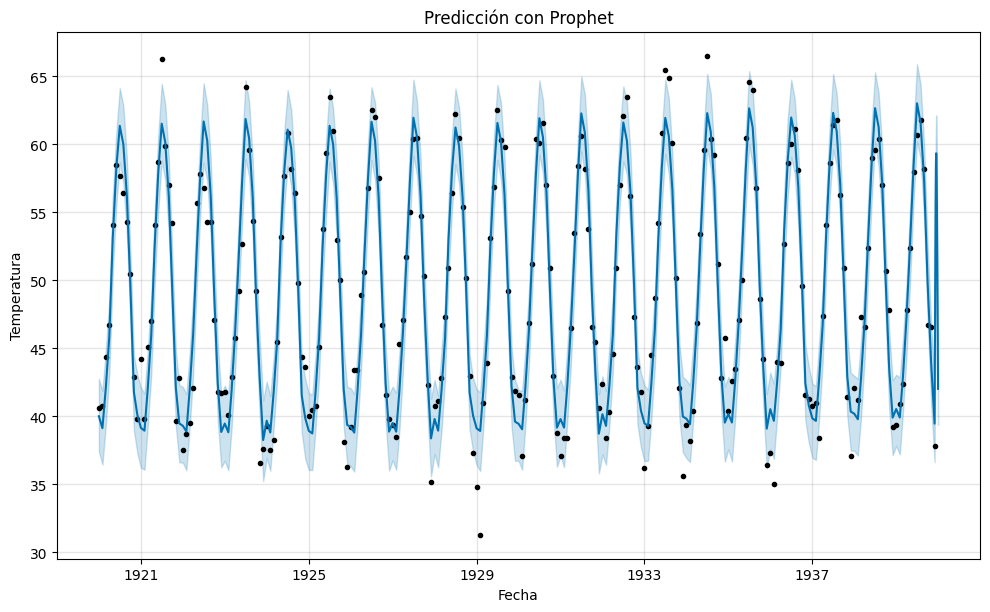

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from prophet import Prophet

# Renombrar columnas
data = df.rename(columns={'Month': 'ds', 'Temperature': 'y'})

# Crear y ajustar el modelo de Prophet
model = Prophet()
model.fit(data)

# Crear un DataFrame con fechas futuras para hacer predicciones
future = model.make_future_dataframe(periods=30)  # 30 días adicionales para predecir
forecast = model.predict(future)

# Visualizar las predicciones
fig = model.plot(forecast)
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title('Predicción con Prophet')
plt.show()


# Redes Neuronales

Epoch 1/100
6/6 [==============================] - 1s 6ms/step - loss: 0.2593
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 0.1923
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1326
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0909
Epoch 5/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0770
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0765
Epoch 7/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0692
Epoch 8/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0654
Epoch 9/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0609
Epoch 10/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0552
Epoch 11/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 12/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0454
Epoch 13/100
6/6 [==============================] - 0s 6ms/st

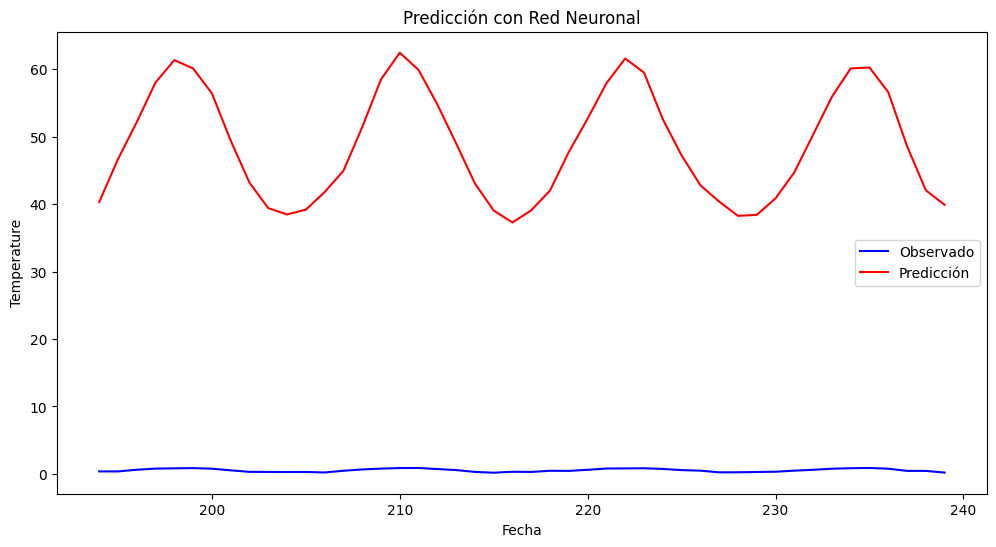

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Normalizar los datos
scaler = MinMaxScaler()
df['Temperature'] = scaler.fit_transform(df['Temperature'].values.reshape(-1, 1))

# Crear secuencias temporales para el entrenamiento
sequence_length = 10  # Longitud de la secuencia temporal
sequences = []
target = []

for i in range(len(df) - sequence_length):
    seq = df['Temperature'].values[i:i+sequence_length]
    label = df['Temperature'].values[i+sequence_length]
    sequences.append(seq)
    target.append(label)

sequences = np.array(sequences)
target = np.array(target)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Crear el modelo de red neuronal
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Evaluar el modelo en datos de prueba
loss = model.evaluate(X_test, y_test)
print(f'Pérdida en datos de prueba: {loss}')

# Realizar predicciones
predictions = model.predict(X_test)

# Deshacer la normalización en las predicciones
predictions = scaler.inverse_transform(predictions)

# Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size+sequence_length:], y_test, label='Observado', color='blue')
plt.plot(df.index[train_size+sequence_length:], predictions, label='Predicción', color='red')
plt.xlabel('Fecha')
plt.ylabel('Temperature')
plt.title('Predicción con Red Neuronal')
plt.legend()
plt.show()


# Comparacion y Evaluacion

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  184
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                 102.554
Date:                           Mon, 04 Sep 2023   AIC                           -195.108
Time:                                   14:28:59   BIC                           -179.255
Sample:                                        0   HQIC                          -188.678
                                           - 184                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3893      0.285      1.368      0.171      -0.169       0.947
ma.L1         -0.1354      0.296     -0.458

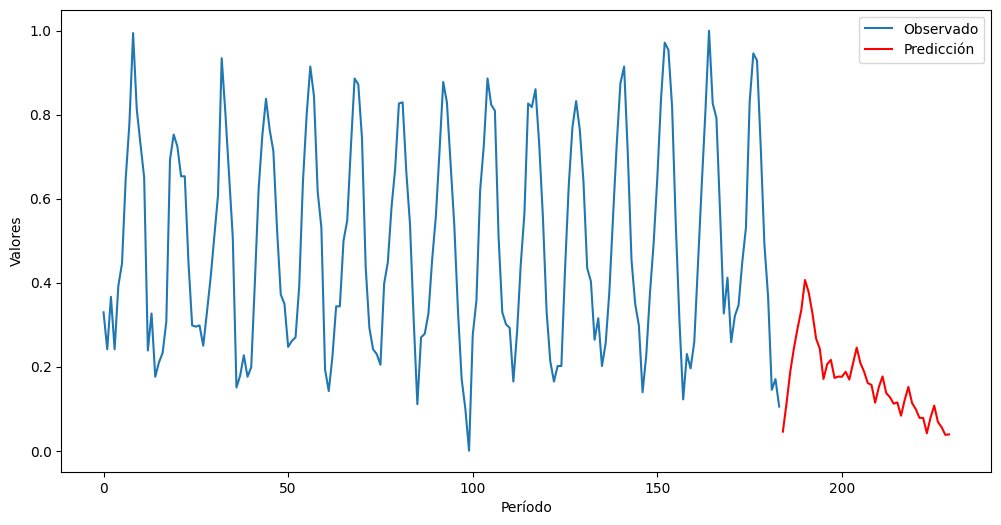

RMSE: 0.43549117651473596
MAE: 0.36782177186245885


In [13]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Ajustar un modelo SARIMA
p, d, q = 1, 1, 1  # Órdenes para el componente ARIMA
P, D, Q, S = 1, 1, 1, 7  # Órdenes para el componente estacional

model = sm.tsa.SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, S))
results = model.fit()

# Ver el resumen del modelo
print(results.summary())

# Realizar predicciones
forecast_period = len(X_test)  # Número de períodos a predecir
forecast = results.get_forecast(steps=forecast_period)
forecast_mean = forecast.predicted_mean

# Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train)), y_train, label='Observado')
plt.plot(range(len(y_train), len(y_train) + forecast_period), forecast_mean, label='Predicción', color='red')
plt.xlabel('Período')
plt.ylabel('Valores')
plt.legend()
plt.show()

# Calcular RMSE y MAE
rmse = mean_squared_error(y_test, forecast_mean, squared=False)
mae = mean_absolute_error(y_test, forecast_mean)

print("RMSE:", rmse)
print("MAE:", mae)


Despues de probar los diferentes tipos de algoritmos, se puede visualizar en las pruebas que Prophet seria la mejor eleccion para estos tipos de datos, gracias a su capacidad para manejar automáticamente las tendencias y patrones estacionales en los datos, lo que elimina la necesidad de ajustes manuales complicados. Además, Prophet es robusto incluso cuando los datos son irregulares o tienen valores faltantes, lo que lo convierte en una herramienta versátil para pronósticos en situaciones del mundo real. Su capacidad para considerar días festivos y eventos especiales también mejora la precisión de las predicciones en contextos complejos.